In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import kmeans_missing, Past_Label, independent_ttest

## Load Data

In [2]:
survey = pd.read_excel('../data/originalData/rMoves_and_2020_for_qianhua.xlsx', usecols=lambda x: 'Unnamed' not in x,)
survey = survey.replace({'Never ': 'Never', 
                         'Less than 1 time per month ': 'Less than 1 time per month',
                         'Less than 1 time per week ': 'Less than 1 time per week'})


demo = pd.read_csv('../data/processedData/rMoves_and_2020_matchLabel.csv', dtype = {'match_id': 'Int64'})
demo = demo.iloc[2838:,:]
info = ['match_id', 
        'PersonalIncome',
        'HouseholdIncome', 
        'What is your age group?',
        'numkids']
demo = demo[info]


# only keep responses from the individual who also took the survey for the household in 2018
sacog_demo = pd.merge(demo, survey, left_on = 'match_id', right_index = True)
sacog_demo.rename(columns = {'What is your age group?': 'age', 'Unnamed: 0': 'id'}, inplace = True)


## Data Cleaning and Data Engineering

In [3]:
def ShoppingBehavior(df):
    ###########################################
    
    # Infer weekly online/instore shopping frequency for both past year and during pandemic
    # Further calculate the share of online shopping during the pandemic
    
    ###########################################
    cat_ = ['PreparedFood', 'Groceries', 'OtherFood', 'PaperCleaning', 'Clothing','HomeOffice','Medication','ChildcareItems']

    freq_dict = {'More than 5 times per week': 5, 
                 '3 - 5 times per week': 4, 
                 '2 - 3 times per week': 2.5,
                 'About 1 time per week': 1, 
                 'Less than 1 time per week': 0.5, #Treat as once every 2 week
                 'Less than 1 time per month': 0.25, # Treat as once per month
                 'Never': 0,
                 'Almost never': 0,
                 'No Response': 0} # Treat no response as never
    
    for cat in cat_:
        df['PastYear-ECommerce-Frequency-'+cat].replace({'No Response': 'Never'},inplace =True)
        df['PastYear-Orders-'+cat] = df['PastYear-ECommerce-Frequency-'+cat].map(freq_dict)
        
        df['May-InStore-Trips-'+cat].replace({-9998: 0}, inplace =True) # treat -9998 (no response) as 0 trip
        df['May-ECommerce-Orders-'+cat].replace({-9998: 0},inplace =True) # treat -9998 (no response) as 0 order
        
        df['May-Trips-'+cat] = df['May-InStore-Trips-'+cat] /2 # divided by 2 as a round trip will count as twice
        df['May-Orders-'+cat] = df['May-ECommerce-Orders-'+cat] # just change to a shorter name
        # If didn't purchase online/instore during the surveyed week, infer shopping frequency from 'May-ECommerce-Frequency-cat'
        df.loc[df['May-ECommerce-Orders-'+cat] == 0, 'May-Orders-'+cat] = df.loc[df['May-ECommerce-Orders-'+cat] == 0]['May-ECommerce-Frequency-'+cat].map(freq_dict)
        df.loc[df['May-InStore-Trips-'+cat] == 0, 'May-Trips-'+cat] = df.loc[df['May-InStore-Trips-'+cat] == 0]['May-InStore-Frequency-'+cat].map(freq_dict)
        
        df['May-Total-'+ cat] = df['May-Orders-'+cat] + df['May-Trips-'+cat]
        df['May-Portion-E' + cat] = df['May-Orders-' + cat] / df['May-Total-'+cat]
        
    return df

In [4]:
# Infer income and age category
def incomeLevel(income):
    if income in ['Under $10,000', '$10,000 - $14,999','$15,000 - $24,999','$25,000 - $49,999']:
        return 'Low income'
    elif income in ['$50,000 - $74,999', '$75,000 - $99,999']:
        return 'Medium income'
    elif income in ['$100,000 - $149,999', '$150,000 - $199,999','$200,000 or more']: 
        return 'High income'
    else:
        return 'Unknown'
    
def ageLevel(age):
    if age in ['18 - 19', '20 - 24', '25 - 34', '35 - 44']:
        return 'Gen Y & Z'
    elif age in ['45 - 54']:
        return 'Gen X'
    elif age in ['55 - 59', '60 - 64', '65 - 74', '75 - 84']:
        return 'Baby Boomer and Older'
    

In [5]:
# Extract shopping channel usage pattern across different commodity types
sacog_demo = ShoppingBehavior(sacog_demo)

# Assign Income & Age group 
sacog_demo.loc[sacog_demo.NumberInHousehold == 1, 'HouseholdIncome'] = sacog_demo.loc[sacog_demo.NumberInHousehold == 1, 'PersonalIncome']
sacog_demo['incomelevel'] = sacog_demo['HouseholdIncome'].apply(incomeLevel)
sacog_demo['ageLevel'] = sacog_demo['age'].apply(ageLevel)

In [6]:
sacog_demo.to_csv('../data/processedData/sacog_demo.csv')

## Descriptive Analysis

In [7]:
cat = ['ChildcareItems', 'Clothing',  'HomeOffice', 'Medication', 'PreparedFood', 'OtherFood', 'PaperCleaning', 'Groceries' ]

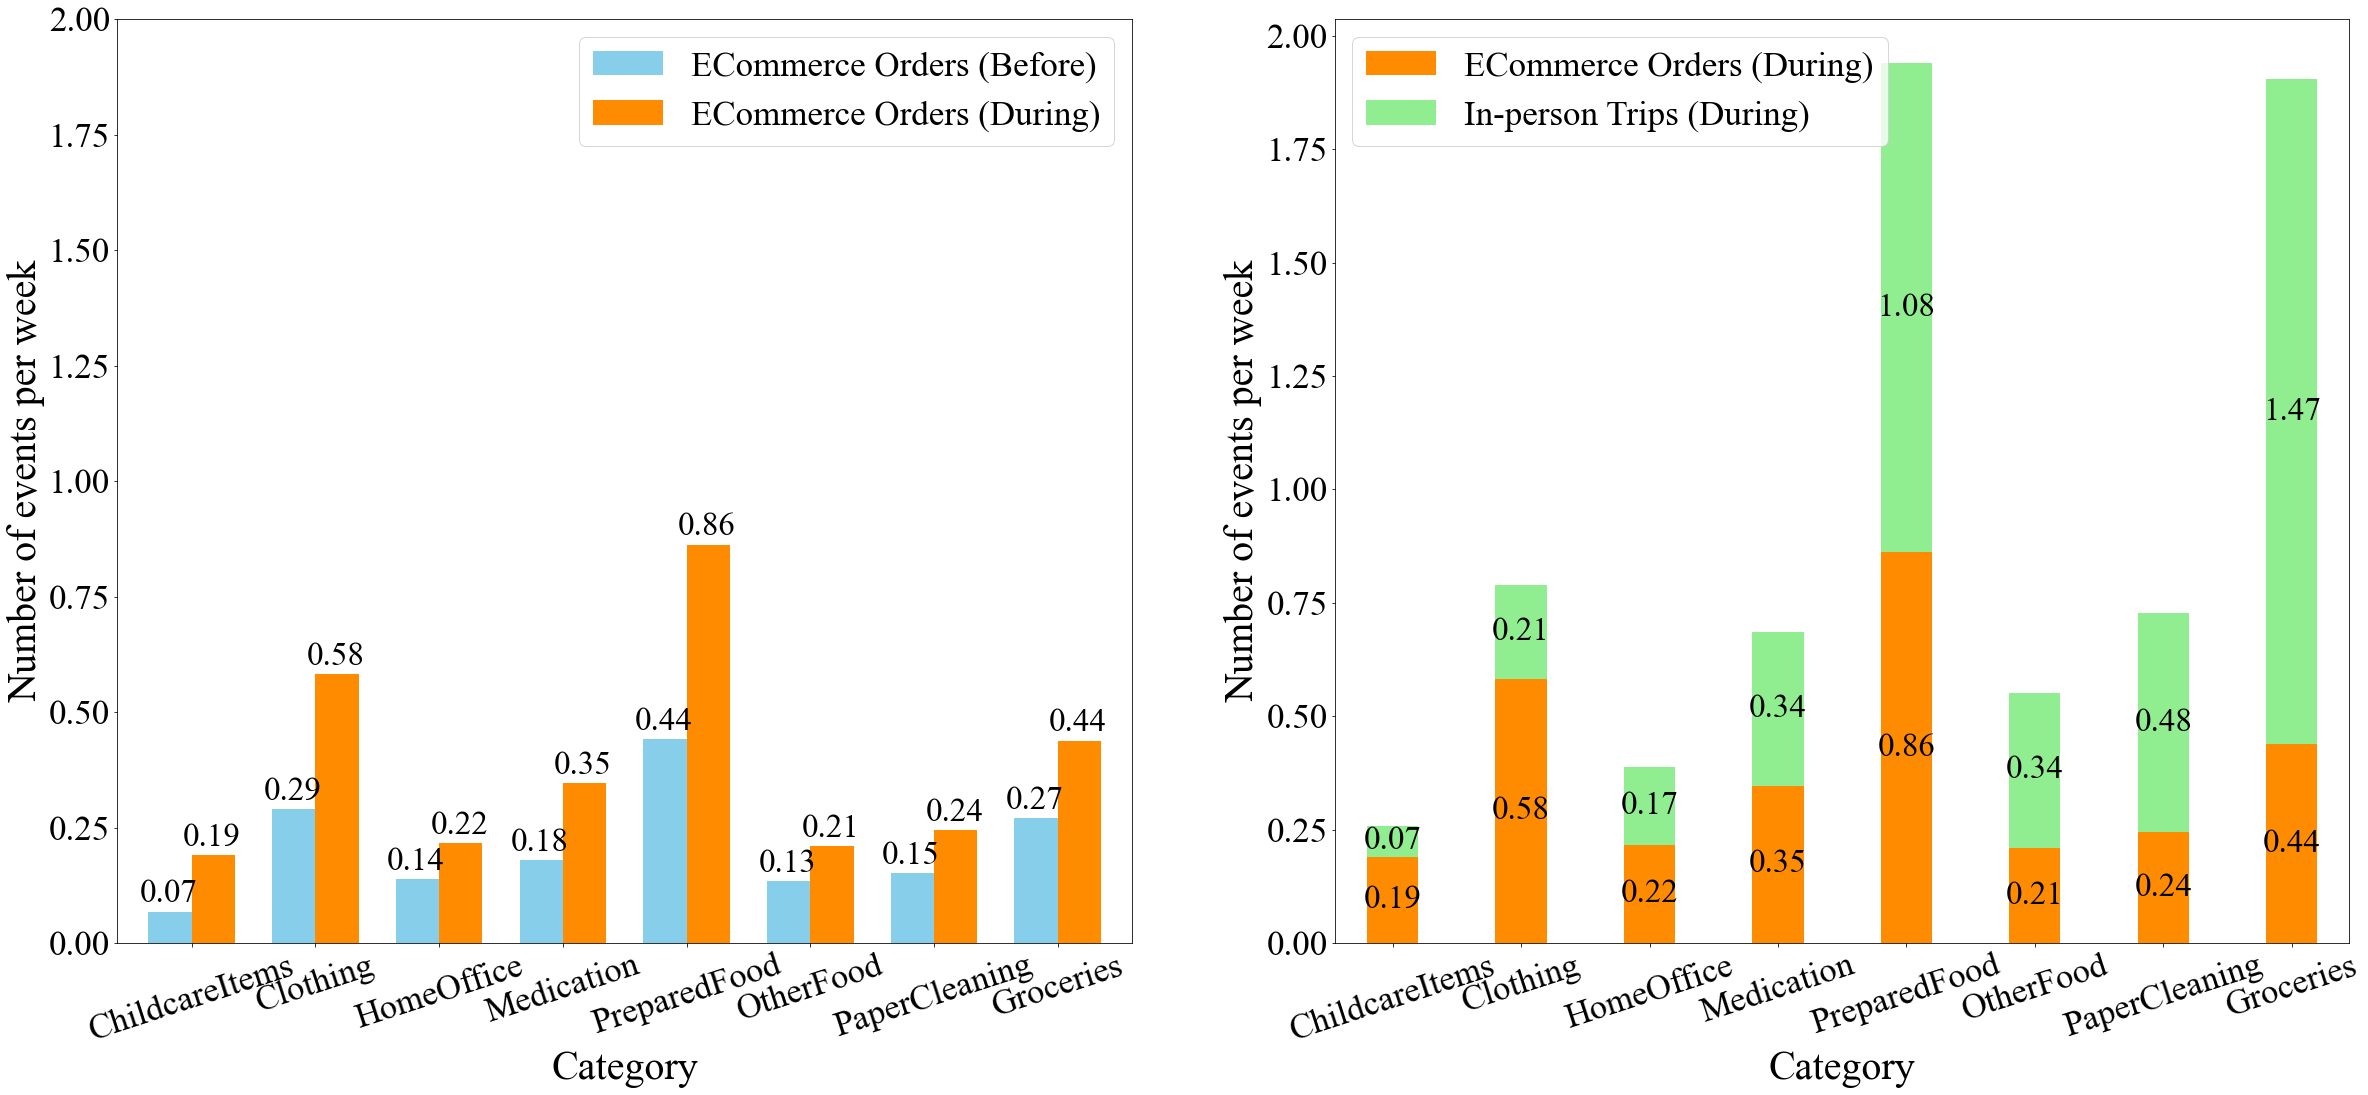

In [8]:
PurchaseFreq = pd.DataFrame(index = cat)
PurchaseFreq['ECommerce Orders (Before)'] = sacog_demo[['PastYear-Orders-'+cat_ for cat_ in cat]].mean().values
PurchaseFreq['ECommerce Orders (During)'] = sacog_demo[['May-Orders-'+cat_ for cat_ in cat]].mean().values
PurchaseFreq['In-person Trips (During)'] = sacog_demo[['May-Trips-'+cat_ for cat_ in cat]].mean().values

plt.rcParams.update({'font.size': 35, 'font.family': 'Times New Roman'}) # fix the font size for matplot
plt.figure(figsize=(40, 17))

plt.subplot(1, 2, 2)
PurchaseFreq.iloc[:,1:].plot(kind='bar', stacked = True, ax = plt.gca(), color = ['darkorange', 'lightgreen']*8, width = 0.4)
plt.xlabel('Category', fontsize=40)
plt.ylabel('Number of events per week', fontsize=40)
#plt.title('Shopping events in May')
plt.xticks(rotation=18)
for p in plt.gca().patches:
    height = p.get_height()
    width = p.get_width()
    x = p.get_x()
    y = p.get_y()
    
    label_text = f'{height:.2f}'
    label_x = x + width/2
    label_y = y + height/2
    plt.gca().text(label_x, label_y, label_text, ha = 'center', va = 'center', fontsize = 33)
    
plt.subplot(1, 2, 1)
PurchaseFreq.iloc[:,[0,1]].plot(kind='bar', ax = plt.gca(), color = ['skyblue','darkorange'], width = 0.7)
for p in plt.gca().patches:
    plt.gca().annotate(round(p.get_height(), 2), (p.get_x() - 0.07, p.get_height() + 0.02), fontsize = 33)
plt.xlabel('Category', fontsize = 40)
plt.ylabel('Number of events per week', fontsize = 40)
plt.ylim(0,2)
#plt.title('Comparison of shopping frequency')
plt.xticks(rotation=18)

plt.savefig('../output/ShoppingFrequency.tiff', dpi=400)

## Shopping Style during- and pre-pandemic

In [9]:
cat = ['ChildcareItems', 'Clothing', 'HomeOffice', 'Medication',  'PreparedFood', 'OtherFood', 'PaperCleaning', 'Groceries' ]

# Find all the observations with complete shopping records for centroid initialization
subset = sacog_demo[~sacog_demo[['May-Portion-E'+cat_ for cat_ in cat]].isna().any(axis = 1)]
subset = subset[['May-Portion-E'+cat_ for cat_ in cat]]

# X is for clustering, contain all 313 records, with nan representing 'no shopping'
X = sacog_demo[['May-Portion-E'+cat_ for cat_ in cat]]

D:\Moomoo Research\ECommerce study\script\utils.py:139: RuntimeWarning: invalid value encountered in double_scalars
  sil_.append((b - a)/max(a,b))
D:\Moomoo Research\ECommerce study\script\utils.py:93: RuntimeWarning: Mean of empty slice
  centroids[j] = np.nanmean(data[clusters == j], axis = 0)


Text(0.5, 1.0, 'Silhouette score')

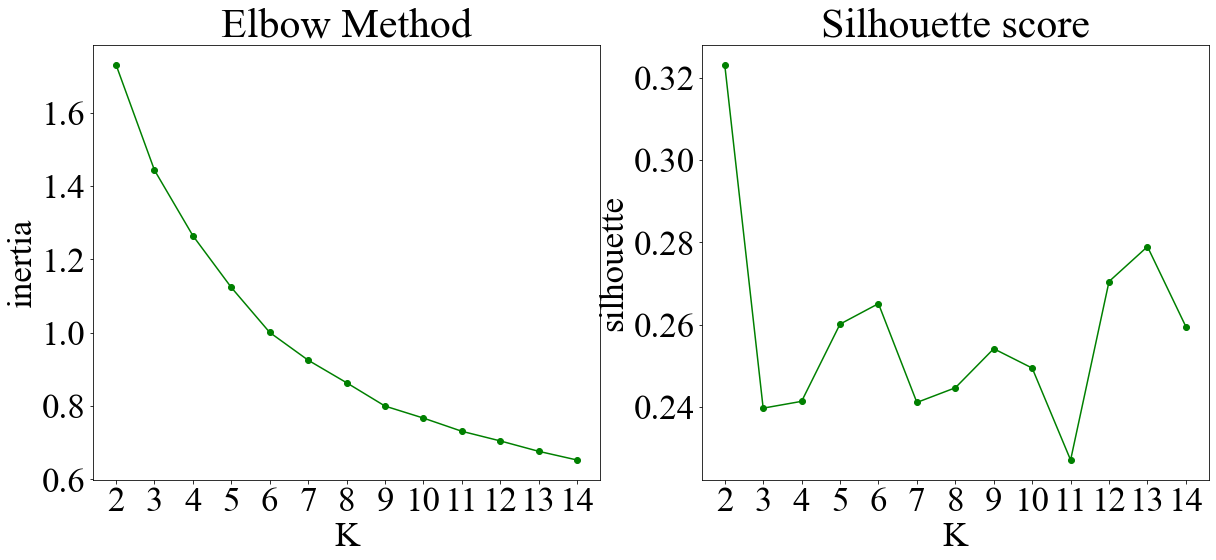

In [10]:
# Weighting means I care more about the similarity or dissimilarity of purchase channel for 
# categories with a higher weight. Categories with a higher shopping rate will get a higher weight
K = range(2, 15)
cost = []
sil = []

# The weight is calculated using the inverse of shopping rate for each category and normalized by the lowest weight - childcareItem
# The weight for grocery is set to 10
weight = np.array(1/(sacog_demo[['May-Portion-E'+cat_ for cat_ in cat]].isna().sum() / 313)) 
weight = weight/weight[0]
weight[-1] = 10

for i in K:
    km = kmeans_missing(potential_centroids = subset, n_clusters = i, weight = weight)
    km.fit(X, max_iter = 10000, number_of_runs = 1000, init = 'kmeans++')
    cost.append(km.costs)
    sil.append(km.silhouette(X))
    
fig, ax = plt.subplots(1, 2, figsize = (20,8))
ax[0].plot(K, cost, 'go-')
ax[0].set_xlabel('K')
ax[0].set_ylabel('inertia')
ax[0].set_xticks(K)
ax[0].set_title('Elbow Method')

ax[1].plot(K, sil, 'go-')
ax[1].set_xlabel('K')
ax[1].set_ylabel('silhouette')
ax[1].set_xticks(K)
ax[1].set_title('Silhouette score')

In [11]:
km5 = kmeans_missing(subset, 5, weight = weight) 
km5.fit(X, max_iter = 10000, number_of_runs = 10000, init = 'kmeans++')

df = pd.DataFrame(km5.centroids, columns = cat)
df
df['size'] = np.unique(km5.labels, return_counts = True)[1]
df['Percentage'] = df['size']/313

In [12]:
df

,ChildcareItems,Clothing,HomeOffice,Medication,PreparedFood,OtherFood,PaperCleaning,Groceries,size,Percentage
0,0.598765,0.801378,0.513889,0.755387,0.034561,0.084848,0.089927,0.039764,57,0.182109
1,0.633333,0.554060,0.431373,0.378049,0.454759,0.459539,0.305483,0.485084,52,0.166134
2,0.641975,0.581991,0.519076,0.343075,0.598228,0.234483,0.256241,0.037716,92,0.293930
3,0.317949,0.102339,0.137500,0.135632,0.164368,0.070707,0.022727,0.011112,83,0.265176
4,0.877334,0.943427,0.891503,0.795843,0.663888,0.773684,0.906800,0.740228,29,0.092652


In [13]:
# Name each group based on the shopping behavior (i.e., share of online orders across eight categories) they manifested 
label_dict = dict(zip([3,0,2,1,4], ['ECommerce Independent', 'ENonFood', 'ENonFood & EPrepFood', 'Partially ECommerce', 'ECommerce Dependent']))
df = df.iloc[[3,0,2,1,4]].rename(index = label_dict)
df.style.background_gradient(subset = cat)

,ChildcareItems,Clothing,HomeOffice,Medication,PreparedFood,OtherFood,PaperCleaning,Groceries,size,Percentage
ECommerce Independent,0.317949,0.102339,0.137500,0.135632,0.164368,0.070707,0.022727,0.011112,83,0.265176
ENonFood,0.598765,0.801378,0.513889,0.755387,0.034561,0.084848,0.089927,0.039764,57,0.182109
ENonFood & EPrepFood,0.641975,0.581991,0.519076,0.343075,0.598228,0.234483,0.256241,0.037716,92,0.293930
Partially ECommerce,0.633333,0.554060,0.431373,0.378049,0.454759,0.459539,0.305483,0.485084,52,0.166134
ECommerce Dependent,0.877334,0.943427,0.891503,0.795843,0.663888,0.773684,0.906800,0.740228,29,0.092652


In [14]:
sacog_demo['label'] = km5.labels
sacog_demo['label'] = sacog_demo['label'].map(label_dict)

### Shopping Style pre-pandemic

In [15]:
X_May = sacog_demo[['May-Orders-'+ cat_ for cat_ in cat]]/4
X_Past = sacog_demo[['PastYear-Orders-'+ cat_ for cat_ in cat]]/4
X_Past.columns = cat
X_May.columns = cat

In [16]:
# records that are greater than 95% quantile are replaced by the mean
for cat_ in cat:
    X_May.loc[X_May[cat_] > X_May[cat_].quantile(.95), cat_] = X_May[cat_].mean()
    

In [17]:
# Calculate the mean online orders for each group
mean_ = X_May.groupby(sacog_demo.label).mean()
mean_ = mean_.reindex(['ECommerce Independent', 'ENonFood', 'ENonFood & EPrepFood', 'Partially ECommerce', 'ECommerce Dependent'])

In [18]:
# Figure out pre-pandemic style for each household
essential = ['PreparedFood', 'Groceries', 'Clothing','PaperCleaning', 'Medication']
cat = ['ChildcareItems', 'Clothing', 'HomeOffice', 'Medication',  'PreparedFood', 'OtherFood', 'PaperCleaning', 'Groceries' ]

def Past_Label(row, kid, centroid):
    
    if kid.loc[row.name] > 0:
        # exclude the household from ECommerce dependent group if never shopped for essential items online
        if sum(row[[cat_ for cat_ in essential+['ChildcareItems']]].isin([0])) > 0:
            # exclude the household from Partially ECommerce if never shopped for grocery online
            if sum(row[['Groceries']].isin([0])) >0:
                # exclude the household from ENonfood & EPrepFood if never shopped for prepared food online
                if sum(row[['PreparedFood']].isin([0])) >0:
                    
                    return np.sum((row - centroid[:2])**2, axis = 1).idxmin()
                else:
                    return np.sum((row - centroid[:3])**2, axis = 1).idxmin()
            
            else:
                return np.sum((row - centroid[:4])**2, axis = 1).idxmin()
        else:
            return np.sum((row - centroid)**2, axis = 1).idxmin()
            
    else:
        if sum(row[[cat_ for cat_ in essential]].isin([0])) > 0:
            if sum(row[['Groceries']].isin([0])) > 0:
                if sum(row[['PreparedFood']].isin([0])) > 0:
                    
                    return np.sum((row[cat[1:]] - centroid[:2][cat[1:]])**2, axis = 1).idxmin()
                else:
                    return np.sum((row[cat[1:]] - centroid[:3][cat[1:]])**2, axis = 1).idxmin()
                
            else:
                return np.sum((row[cat[1:]] - centroid[:4][cat[1:]])**2, axis = 1).idxmin()

        else:
            return np.sum((row[cat[1:]] - centroid[cat[1:]])**2, axis = 1).idxmin()
    

In [19]:
sacog_demo['past_label'] = X_Past.apply(lambda x: Past_Label(x, sacog_demo['numkids'], mean_), axis = 1)
sacog_demo.to_csv('../data/sacog_demo_label.csv')

In [20]:
ct = pd.crosstab(sacog_demo.past_label, sacog_demo.label, margins = True)[['ECommerce Independent', 'ENonFood', 'ENonFood & EPrepFood', 'Partially ECommerce', 'ECommerce Dependent', 'All']]
ct = ct.reindex(['ECommerce Independent', 'ENonFood', 'ENonFood & EPrepFood', 'Partially ECommerce', 'ECommerce Dependent', 'All'])
ct

label,ECommerce Independent,ENonFood,ENonFood & EPrepFood,Partially ECommerce,ECommerce Dependent,All
past_label,,,,,,
ECommerce Independent,55,35,46,24,12,172
ENonFood,9,13,18,15,5,60
ENonFood & EPrepFood,7,3,15,5,5,35
Partially ECommerce,5,4,9,6,3,27
ECommerce Dependent,7,2,4,2,4,19
All,83,57,92,52,29,313


In [25]:
import plotly.graph_objects as go

df = pd.DataFrame({'Past style': sacog_demo.past_label, 
              'May style': sacog_demo.label})

fig = go.Figure(data = [go.Sankey(
                        textfont = dict(color = 'Black', family='Times New Roman', size = 18),
                        node = dict(
                        pad = 10,
                        thickness = 20,
                        label = ['ECommerce Dependent', 'ECommerce Independent', 'ENonFood', 'ENonFood & EPrepFood', 'Partially ECommerce',
                                 'ECommerce Dependent', 'ECommerce Independent', 'ENonFood', 'ENonFood & EPrepFood','Partially ECommerce'],
                        color = ['salmon','teal','olive','orange','pink',
                                'salmon','teal','olive','orange','pink'],
                        ),
                        link = dict(
                            source = [0]*5 + [1]*5 + [2]*5 + [3]*5 + [4]*5,
                            target = [5,6,7,8,9]*6,
                            value = list(df.groupby('Past style')['May style'].value_counts().sort_index())
                        ))]
               )

fig.update_layout(title_text = 'Dynamic of Shopping Style')
fig.show()


### Heterogeneity in shopping style across generations

In [26]:
generation_order = ['Gen Y & Z', 'Gen X', 'Baby Boomer and Older']
group_order = ['ECommerce Independent', 'ENonFood', 'ENonFood & EPrepFood', 'Partially ECommerce', 'ECommerce Dependent']

In [27]:
# Calculate the shopping style distribution by generation cohort, and see if the proportion of a style within a generation 
# cohort is significantly less or greater than the proportion among the whole population
def genHetero(data, label, genorder,grouporder):
    
    df = data.groupby('ageLevel')[label].value_counts(normalize = True).unstack().reindex(genorder)[grouporder].T
    df['Total'] = data[label].value_counts(normalize=True)
    df = df.applymap('{:.0%}'.format).applymap(str)
    df.rename_axis(index=None)
    
    sig = dict(zip(generation_order, [[],[],[]]))
    for gen in genorder:
        for style in grouporder:
            group_mean = data[label] == style
            gen_mean = data[data.ageLevel == gen][label] == style
            _, _, _, p = independent_ttest(group_mean, gen_mean, 0.05)
            sig[gen].append(p)
    p_ = pd.DataFrame(sig).applymap(lambda x: ''.join(['*' for t in [.1, .05, .01] if x<=t]))
    p_['Total'] = np.array(['']*len(grouporder))
    p_.set_axis(grouporder, inplace = True)
    
    display(df + p_)  
    

In [28]:
genHetero(sacog_demo, 'past_label', generation_order, group_order)                  
         

ageLevel,Gen Y & Z,Gen X,Baby Boomer and Older,Total
past_label,,,,
ECommerce Independent,52%,56%,57%,55%
ENonFood,15%,22%,21%,19%
ENonFood & EPrepFood,13%,11%,10%,11%
Partially ECommerce,11%,7%,7%,9%
ECommerce Dependent,8%,4%,5%,6%


In [29]:
genHetero(sacog_demo, 'label', generation_order, group_order)     

ageLevel,Gen Y & Z,Gen X,Baby Boomer and Older,Total
label,,,,
ECommerce Independent,27%,19%*,29%,27%
ENonFood,15%,20%,21%,18%
ENonFood & EPrepFood,34%,35%,23%*,29%
Partially ECommerce,18%,17%,16%,17%
ECommerce Dependent,6%,9%,12%,9%


In [30]:
EInd = sacog_demo[sacog_demo.past_label == 'ECommerce Independent']
genHetero(EInd, 'label', generation_order, group_order)

ageLevel,Gen Y & Z,Gen X,Baby Boomer and Older,Total
label,,,,
ECommerce Independent,32%,20%*,36%,32%
ENonFood,15%,30%,21%,20%
ENonFood & EPrepFood,32%,23%,23%,27%
Partially ECommerce,17%,17%,10%,14%
ECommerce Dependent,3%*,10%,9%,7%


### Future Intention

In [31]:
intent = [
 'DoInStage23-ContactlessDoor',
 'DoInStage23-CurbsidePickup',
 'DoInStage23-InStorePickup',
 'DoInStage23-VisitRetail',
 'DoInStage23-VisitRestaurant',
 ]

In [32]:
pd.options.display.float_format = '{:.1f}'.format
df = sacog_demo[sacog_demo != -9998].groupby('label')[intent].mean().reindex(group_order)
df = df.append(pd.DataFrame(sacog_demo[sacog_demo != -9998][intent].mean()).T.rename({0:'Total'}))

In [33]:
sig = dict(zip(intent, [[] for _ in range(5)]))
for intention in intent:
    for style in group_order:
        ppl_mean = sacog_demo[sacog_demo[intention] != -9998][intention]
        group_mean = sacog_demo[sacog_demo[intention] != -9998][sacog_demo.label == style][intention]
        _, _, _, p = independent_ttest(ppl_mean, group_mean, 0.05)
        sig[intention].append(p)
p_ = pd.DataFrame(sig).rename(dict(zip(range(5), group_order))).applymap(lambda x: ''.join(['*' for t in [.1, .05, .01] if x<=t]))
p_.loc['Total'] = [''] * len(intent)
p_
df.round(1).astype(str) + p_

<ipython-input-33-4aef0184266a>:5: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,DoInStage23-ContactlessDoor,DoInStage23-CurbsidePickup,DoInStage23-InStorePickup,DoInStage23-VisitRetail,DoInStage23-VisitRestaurant
ECommerce Independent,3.0*,2.8**,3.0,3.8**,3.0
ENonFood,2.7***,2.8**,2.9*,3.6,2.9
ENonFood & EPrepFood,3.4,3.7***,3.6***,3.6,2.9
Partially ECommerce,3.9***,3.4,3.3,3.2*,2.8
ECommerce Dependent,4.0***,3.3,2.8*,2.6***,2.4**
Total,3.3,3.2,3.2,3.5,2.9
